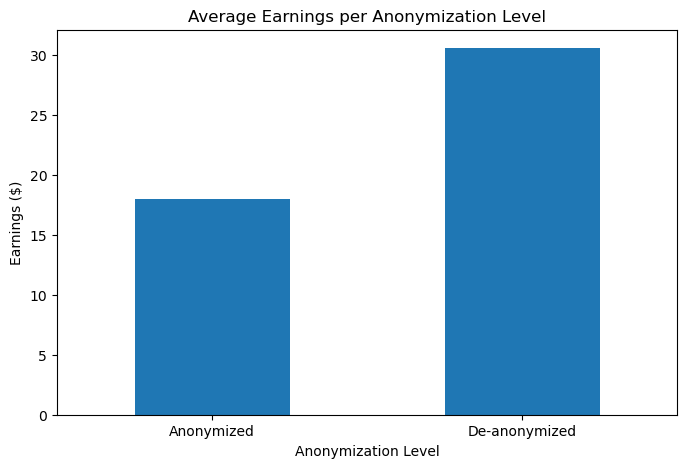

In [12]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Define User Class
class User:
    def __init__(self, user_id, statements):
        """
        statements: List of preference statements, where each statement is a dictionary
        Example:
        [
            {"A": "De-anonymized", "P": "Advertisers", "R": ["Targeted Ads", "Email Marketing"]},
            {"A": "Anonymized", "P": "Retailers", "R": ["Market Research"]}
        ]
        """
        self.user_id = user_id
        self.statements = statements  # List of user data-sharing statements
        self.earnings = 0

    def get_relevant_statements(self, platform_type):
        """Returns all statements that match a given platform type."""
        return [s for s in self.statements if s["P"] == platform_type]

# Define Platform Class
class Platform:
    def __init__(self, platform_type, budget, value_per_purpose):
        """
        platform_type: "Advertisers" or "Retailers"
        budget: Total budget for data purchases
        value_per_purpose: Dict {Purpose: Base Value}
        Example: {"Targeted Ads": 50, "Email Marketing": 30, "Market Research": 20}
        """
        self.platform_type = platform_type
        self.budget = budget
        self.value_per_purpose = value_per_purpose

    def bid_for_data(self, purpose, anonymization):
        """Determines bid amount based on anonymization level and purpose."""
        if purpose not in self.value_per_purpose:
            return 0  # Platform doesn’t need this data
        
        base_value = self.value_per_purpose[purpose]
        price = base_value if anonymization == "De-anonymized" else base_value * 0.5  # Anonymized data is worth less
        return min(price, self.budget)  # Platform won't exceed budget

# Define Broker (Papaya) Class
class Broker:
    def __init__(self, commission_rate=0.1):
        self.commission_rate = commission_rate  # Papaya takes a small cut

    def process_transactions(self, users, platforms):
        total_transactions = 0
        earnings_data = []
        
        for user in users:
            for platform in platforms:
                user_statements = user.get_relevant_statements(platform.platform_type)
                for statement in user_statements:
                    for purpose in statement["R"]:  # Iterate over all allowed purposes
                        price = platform.bid_for_data(purpose, statement["A"])
                        if price > 0:
                            payout = price * (1 - self.commission_rate)
                            user.earnings += payout  # Pay user
                            platform.budget -= price
                            total_transactions += 1

                            # Collect transaction data for analysis
                            earnings_data.append({
                                "User_ID": user.user_id,
                                "Platform": platform.platform_type,
                                "Purpose": purpose,
                                "Anonymization": statement["A"],
                                "Earnings": payout
                            })

        return total_transactions, earnings_data

# Initialize platforms
platforms = [
    Platform("Advertisers", budget=5000, value_per_purpose={"Targeted Ads": 50, "Email Marketing": 30}),
    Platform("Retailers", budget=4000, value_per_purpose={"Market Research": 40, "Product Recommendation": 25}),
]

# Define users with structured (P, R, A) preferences
users = [
    User(1, [
        {"A": "De-anonymized", "P": "Advertisers", "R": ["Targeted Ads", "Email Marketing"]},
        {"A": "Anonymized", "P": "Retailers", "R": ["Market Research"]}
    ]),
    User(2, [
        {"A": "Anonymized", "P": "Advertisers", "R": ["Email Marketing"]},
        {"A": "De-anonymized", "P": "Retailers", "R": ["Product Recommendation"]}
    ]),
    User(3, [
        {"A": "Anonymized", "P": "Advertisers", "R": ["Targeted Ads"]},
        {"A": "De-anonymized", "P": "Retailers", "R": ["Market Research", "Product Recommendation"]}
    ]),
]

# Initialize the broker
broker = Broker(commission_rate=0.1)

# Run the simulation for multiple rounds and collect data
NUM_ROUNDS = 20
all_earnings_data = []

for round in range(NUM_ROUNDS):
    transactions, earnings_data = broker.process_transactions(users, platforms)
    all_earnings_data.extend(earnings_data)

# Convert results to a DataFrame
df = pd.DataFrame(all_earnings_data)

# Aggregate results for analysis
earnings_by_anonymization = df.groupby("Anonymization")["Earnings"].mean()
earnings_by_purpose = df.groupby("Purpose")["Earnings"].mean()
platform_spending = df.groupby("Platform")["Earnings"].sum()

# Plot earnings vs. anonymization levels
plt.figure(figsize=(8, 5))
earnings_by_anonymization.plot(kind="bar")
plt.title("Average Earnings per Anonymization Level")
plt.ylabel("Earnings ($)")
plt.xlabel("Anonymization Level")
plt.xticks(rotation=0)
plt.show()


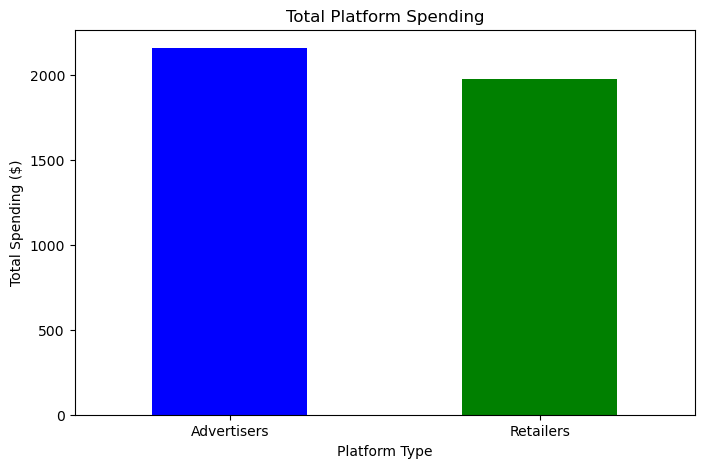

In [13]:
# Plot platform spending distribution
plt.figure(figsize=(8, 5))
platform_spending.plot(kind="bar", color=["blue", "green"])
plt.title("Total Platform Spending")
plt.ylabel("Total Spending ($)")
plt.xlabel("Platform Type")
plt.xticks(rotation=0)
plt.show()

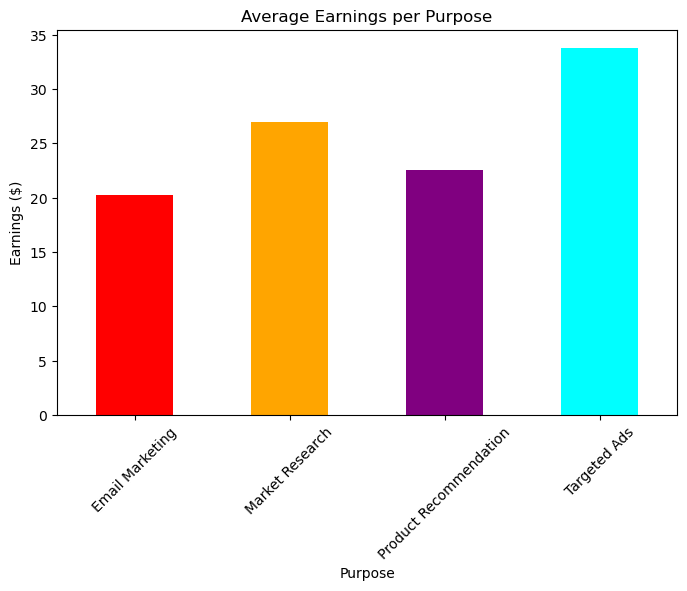

In [14]:
# Plot earnings distribution across purposes
plt.figure(figsize=(8, 5))
earnings_by_purpose.plot(kind="bar", color=["red", "orange", "purple", "cyan"])
plt.title("Average Earnings per Purpose")
plt.ylabel("Earnings ($)")
plt.xlabel("Purpose")
plt.xticks(rotation=45)
plt.show()

In [15]:
df

,User_ID,Platform,Purpose,Anonymization,Earnings
0,1,Advertisers,Targeted Ads,De-anonymized,45.0
1,1,Advertisers,Email Marketing,De-anonymized,27.0
2,1,Retailers,Market Research,Anonymized,18.0
3,2,Advertisers,Email Marketing,Anonymized,13.5
4,2,Retailers,Product Recommendation,De-anonymized,22.5
...,...,...,...,...,...
155,2,Advertisers,Email Marketing,Anonymized,13.5
156,2,Retailers,Product Recommendation,De-anonymized,22.5
157,3,Advertisers,Targeted Ads,Anonymized,22.5
158,3,Retailers,Market Research,De-anonymized,36.0
